# **1. Installing Datasets**

In [1]:
!pip install opendatasets --quiet

import torch
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: damifiance
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.20GB/s]

# **2. Importing Modules**


In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


# **3. Data Preprocessing**

In [8]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [9]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis = 1, inplace = True)
print(data_df.shape)

(18185, 11)


In [10]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [11]:
print(data_df['Class'].unique())

[1 0]


In [12]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [15]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# **4. Splitting**

In [16]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:, -1])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [26]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [27]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


# **5. dataset Class**

In [30]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [33]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [56]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size=32, shuffle = True)


#**6. Model Creating**

In [57]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.Linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.Linear(x)
    x = self.sigmoid(x)

    return x

model = MyModel().to(device)

In [58]:
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [59]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [61]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for data in train_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    # print(prediction.shape)
    # print(prediction.squeeze(1).shape)
    # The squeeze(1) changes the shape of the data without changing the contents
    # This is possible bc the prediction's shape was [8,1]
    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_validation += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()

      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_validation/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() * 100, 4))

  print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
            Validation Loss: {round(total_loss_validation/1000, 4)}, Validation Accuracy: {round(total_acc_validation/validation_data.__len__() * 100, 4)}''')
  print("="*25)

Epoch no. 1 Train Loss: 0.0176, Train Accuracy: 98.5859
            Validation Loss: 0.0042, Validation Accuracy: 98.4971
Epoch no. 2 Train Loss: 0.0172, Train Accuracy: 98.5859
            Validation Loss: 0.0041, Validation Accuracy: 98.3871
Epoch no. 3 Train Loss: 0.0168, Train Accuracy: 98.6566
            Validation Loss: 0.0041, Validation Accuracy: 98.3871
Epoch no. 4 Train Loss: 0.0166, Train Accuracy: 98.6095
            Validation Loss: 0.004, Validation Accuracy: 98.3871
Epoch no. 5 Train Loss: 0.0165, Train Accuracy: 98.5309
            Validation Loss: 0.004, Validation Accuracy: 98.3871
Epoch no. 6 Train Loss: 0.0163, Train Accuracy: 98.6409
            Validation Loss: 0.004, Validation Accuracy: 98.3871
Epoch no. 7 Train Loss: 0.0163, Train Accuracy: 98.633
            Validation Loss: 0.004, Validation Accuracy: 98.3504
Epoch no. 8 Train Loss: 0.0163, Train Accuracy: 98.6016
            Validation Loss: 0.004, Validation Accuracy: 98.4238
Epoch no. 9 Train Loss: 0.0163

In [63]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

  print(f"Accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)}")

Accuracy: 99.0103


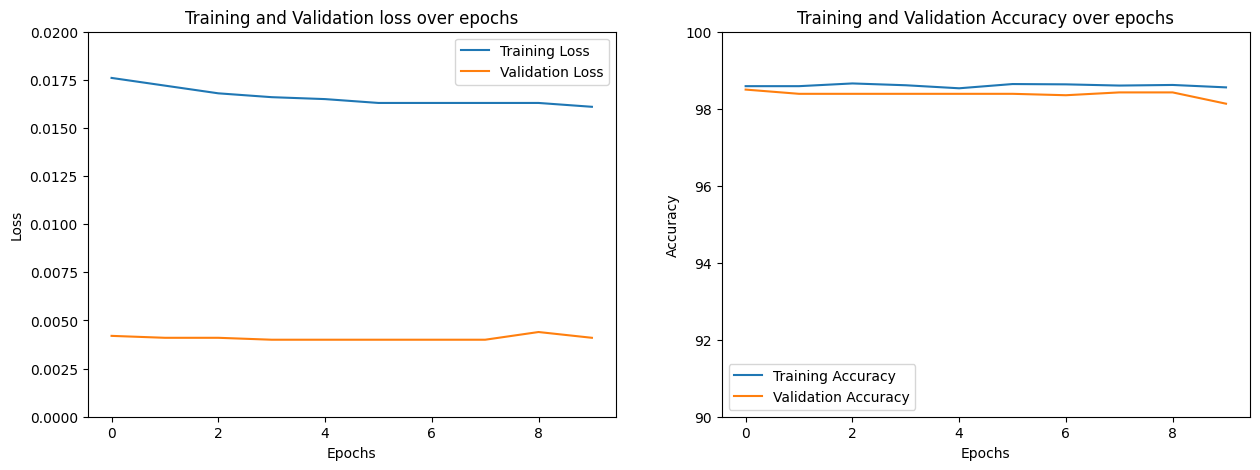

In [70]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 0.02])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([90, 100])
axs[1].legend()

plt.show()

In [71]:
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [76]:
# Now If you (what I entered is an index with some changes)
my_prediction = model(torch.tensor([0.444378, 0.503406, 0.775438, 0.744648, 0.424833, 0.666614, 0.741665, 0.537028, 0.844497, 0.348316], dtype = torch.float32).to(device))
print(round(my_prediction.item()))

# It will print out the estimated result

0
